# Sentimental analysis 
Lucas Caceres, Yasamin Esmaeili,Shiying Li, David Ren

In [3]:
#Do once at start

#!pip install numpy
#!pip install pandas
#!pip install sentence-transformers torch tf-kera
#!pip uninstall -y torch torchvision torchaudio
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

#!pip install "transformers==4.46.2" "sentence-transformers==3.0.1"
#!sudo chown -R $USER ~/.cache/huggingface
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')



In [4]:
#Source "kashishparmar02/social-media-sentiments-analysis-dataset"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity


In [5]:
data = '../Data/sentimentdataset.csv'
df = pd.read_csv(data)
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
#print(df.head())
#print(df.loc[12, 'Text'])

In order to train a model off to detect the sentiment I am going to turn all properties to a string, and
treat the embeedings as one large word

In [22]:
#Data categories
#types = ['Text','Sentiment','Timestamp','User','Platform','Hashtags','Retweets','Likes','Country','Year','Month','Day','Hour']
types = ['Text','Timestamp','User','Platform','Hashtags','Retweets','Likes','Country','Year','Month','Day','Hour']

def create_embeeding(row,types,df):
    #Data categories
    word = []
    for cat in range(len(types)):
        word.append(f'{types[cat]:}: {df.loc[row,types[cat]]}')
    return '|'.join(word)

datapoints = []
for review in range(len(df)):
    datapoints.append( create_embeeding(review,types,df))
print(datapoints)


['Text:  Enjoying a beautiful day at the park!              |Timestamp: 2023-01-15 12:30:00|User:  User123      |Platform:  Twitter  |Hashtags:  #Nature #Park                            |Retweets: 15.0|Likes: 30.0|Country:  USA      |Year: 2023|Month: 1|Day: 15|Hour: 12', 'Text:  Traffic was terrible this morning.                 |Timestamp: 2023-01-15 08:45:00|User:  CommuterX    |Platform:  Twitter  |Hashtags:  #Traffic #Morning                        |Retweets: 5.0|Likes: 10.0|Country:  Canada   |Year: 2023|Month: 1|Day: 15|Hour: 8', 'Text:  Just finished an amazing workout! 💪               |Timestamp: 2023-01-15 15:45:00|User:  FitnessFan   |Platform:  Instagram |Hashtags:  #Fitness #Workout                        |Retweets: 20.0|Likes: 40.0|Country:  USA        |Year: 2023|Month: 1|Day: 15|Hour: 15', 'Text:  Excited about the upcoming weekend getaway!        |Timestamp: 2023-01-15 18:20:00|User:  AdventureX   |Platform:  Facebook |Hashtags:  #Travel #Adventure                     

In [23]:
#The cache is so we don't have to retrain it every time we re-use it
cache_dir = os.path.join(os.getcwd(), ".cache", "huggingface")
os.environ.update({
    "HF_HOME": cache_dir,
    "TRANSFORMERS_CACHE": cache_dir,
    "HF_DATASETS_CACHE": cache_dir
})
os.makedirs(cache_dir, exist_ok=True)
print("Using local Hugging Face cache at:", cache_dir)

sent_trans_model = SentenceTransformer("all-MiniLM-L6-v2", cache_folder=cache_dir)
print('Loaded sentence-transformer into variable `sent_trans_model`.')


Using local Hugging Face cache at: /Users/lucascaceres/Documents/ProjectRene/Sentiment_Analysis_NYUDSFall2025/notebooks/.cache/huggingface
Loaded sentence-transformer into variable `sent_trans_model`.


In [24]:
#Train model
embeddings = sent_trans_model.encode(datapoints, show_progress_bar=True)

Batches: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


In [25]:
import numpy as np

embeddings = np.asarray(embeddings)
embeddings_df = pd.DataFrame(embeddings)

datapoints_df = pd.DataFrame({'text_combined': datapoints})

min_len = min(len(embeddings_df), len(datapoints_df), len(df))
embeddings_df = embeddings_df.iloc[:min_len].reset_index(drop=True)
datapoints_df = datapoints_df.iloc[:min_len].reset_index(drop=True)
df_trim = df.reset_index(drop=True).iloc[:min_len]


In [26]:
from sklearn.metrics.pairwise import cosine_similarity

query = input("Enter a Query: ")
q_emb = sent_trans_model.encode([query])
#print(q_emb)
sims = cosine_similarity(q_emb, embeddings_df.values)[0]

top_k = 5
top_k_indices = sims.argsort()[-top_k:][::-1]

results_text = datapoints_df.iloc[top_k_indices].reset_index(drop=True)
results_meta = df_trim.iloc[top_k_indices].reset_index(drop=True)
results = pd.concat([results_text, results_meta], axis=1)

print('Top matches for:', query)
print(results[['text_combined','Sentiment','Hashtags','Likes','Country']].to_string(index=False))


Top matches for: fear
                                                                                                                                                                                                                                                                                                                             text_combined      Sentiment                                       Hashtags  Likes         Country
                                            Text:  Feeling a sense of fear after watching a thriller movie. |Timestamp: 2023-02-11 21:15:00|User:  ThrillerFan     |Platform:  Instagram |Hashtags:  #Fear #ThrillerMovie                         |Retweets: 15.0|Likes: 30.0|Country:  USA          |Year: 2023|Month: 2|Day: 11|Hour: 21  Fear           #Fear #ThrillerMovie                            30.0   USA          
                                               Text:  The fear of the unknown is keeping me up at night.    |Timestamp: 2023-02-20 21:15:00|User: 

   Emotion  AverageSimilarity
4      joy           0.222096
1  sadness           0.177294
3     fear           0.136528
2    guilt           0.130531
0    anger           0.127507


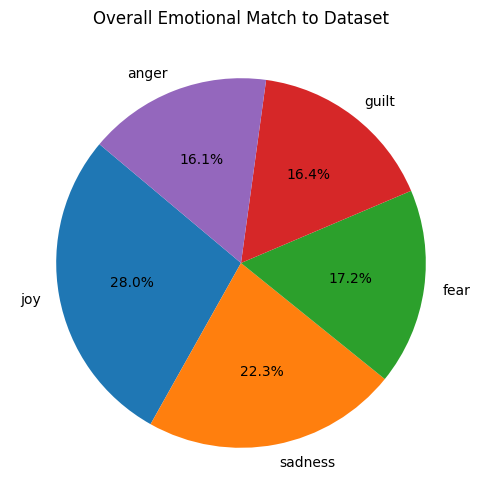

In [27]:
queries = ["anger", "sadness", "guilt", "fear", "joy"]

query_embeddings = sent_trans_model.encode(queries)
similarity_matrix = cosine_similarity(query_embeddings, embeddings_df.values)

avg_scores = similarity_matrix.mean(axis=1)

emotion_scores = pd.DataFrame({
    "Emotion": queries,
    "AverageSimilarity": avg_scores
}).sort_values(by="AverageSimilarity", ascending=False)

print(emotion_scores)

plt.figure(figsize=(6,6))
plt.pie(
    emotion_scores["AverageSimilarity"],
    labels=emotion_scores["Emotion"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Overall Emotional Match to Dataset")
plt.show()